In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader, Dataset
import os
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import warnings  

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

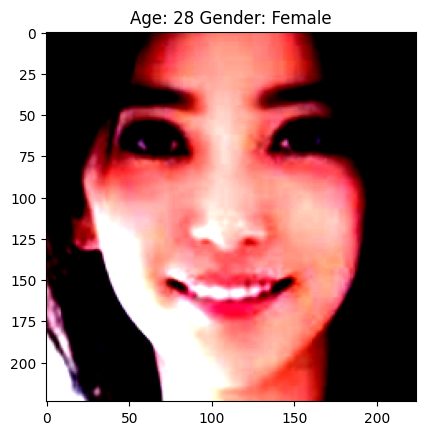

In [2]:
class UTKFaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)
        self.ages = []
        self.genders = []
        self.transform = transform

        valid_images = []
        for image in self.images:
            try:
                age, gender = image.split('_')[:2]
                self.ages.append(int(age))
                self.genders.append(int(gender))
                valid_images.append(image)
            except Exception as e:
                print(f"Skipping image {image}: {e}")
        self.images = valid_images  # only keep valid ones
        self.ages = [x / 110.0 for x in self.ages]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        age = self.ages[idx]
        gender = self.genders[idx]

        return image, age, gender

def collate_fn(batch):
    images, ages, genders = zip(*batch)
    images = torch.stack(images)
    ages = torch.tensor(ages, dtype=torch.float32) 
    genders = torch.tensor(genders, dtype=torch.long)
    return images, ages, genders

image_dir = '/kaggle/input/utkface-new/crop_part1'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Apply different transforms to train and validation sets
dataset = UTKFaceDataset(image_dir, transform=None)  # No transform here if using separate train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

images, ages, genders = next(iter(train_loader))

plt.imshow(images[0].permute(1, 2, 0))
plt.title(f'Age: {int(ages[0]*110)} Gender: {"Man" if genders[0]==0 else "Female"}')
plt.show()

In [3]:
class UTKFace(nn.Module):
    def __init__(self, hidden_dim=512, output_age_dim=1, output_gender_dim=1):
        super().__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        in_features = base_model.classifier[1].in_features
        
        # Age regressor with dropout
        self.age_regressor = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, output_age_dim),
            nn.Sigmoid()
        )
        
        # Gender classifier
        self.gender_classifier = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, output_gender_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1) 
        age = self.age_regressor(x)
        gender = self.gender_classifier(x)
        return age, gender


def train_model(model, train_loader, val_loader, optimizer, num_epochs=20, patience=3, device='cpu'):
    loss_age_fn = nn.SmoothL1Loss()
    loss_gender_fn = nn.BCEWithLogitsLoss()

    best_loss = float('inf')
    best_model = None
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}")
        total_age_loss = 0
        total_gender_correct = 0
        total = 0

        for images, ages, genders in loop:
            images, ages, genders = images.to(device), ages.to(device).float(), genders.to(device).float()

            optimizer.zero_grad()
            pred_age, pred_gender = model(images)
    

            age_loss = loss_age_fn(pred_age.squeeze(1), ages)
            gender_loss = loss_gender_fn(pred_gender.squeeze(1), genders)

            loss = age_loss + gender_loss
            loss.backward()
            optimizer.step()

            total_age_loss += age_loss.item()
            pred_gender_label = torch.sigmoid(pred_gender).squeeze(1).round()
            total_gender_correct += (pred_gender_label == genders).sum().item()
            total += genders.size(0)

            loop.set_postfix({
                "Age Loss": f"{age_loss.item():.4f}",
                "Gender Acc": f"{100 * total_gender_correct / total:.2f}%"
            })

        print(f"Train | Age Loss: {total_age_loss/len(train_loader):.4f} | Gender Acc: {100 * total_gender_correct / total:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        total_age_loss = 0
        total_gender_correct = 0
        total = 0
        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}")
            for images, ages, genders in loop:
                images, ages, genders = images.to(device), ages.to(device).float(), genders.to(device).float()
                pred_age, pred_gender = model(images)

                age_loss = loss_age_fn(pred_age.squeeze(1), ages)
                gender_loss = loss_gender_fn(pred_gender.squeeze(1), genders)

                val_loss += age_loss.item() + gender_loss.item()
                total_age_loss += age_loss.item()
                pred_gender_label = torch.sigmoid(pred_gender).squeeze(1).round()
                total_gender_correct += (pred_gender_label == genders).sum().item()
                total += genders.size(0)

                loop.set_postfix({
                    "Val Age Loss": f"{age_loss.item():.4f}",
                    "Val Gender Acc": f"{100 * total_gender_correct / total:.2f}%"
                })

        print(f"Val | Age Loss: {total_age_loss/len(val_loader):.4f} | Gender Acc: {100 * total_gender_correct / total:.2f}%")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    if best_model:
        model.load_state_dict(best_model)

    return model

In [4]:
def predict_image(model, image_path, transform, device='cpu'):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        age_pred, gender_pred = model(image)
        age_pred = int(age_pred.item()*110)
        gender_pred = torch.sigmoid(gender_pred).item()
        gender_label = 'Male' if round(gender_pred) == 0 else 'Female'
    
    print(f"Predicted Age: {age_pred:.2f}")
    print(f"Predicted Gender: {gender_label}")
    return age_pred, gender_label, image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UTKFace().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trained_model = train_model(model, train_loader, val_loader, optimizer, device=device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]
[Train] Epoch 1/20: 100%|██████████| 245/245 [01:58<00:00,  2.07it/s, Age Loss=0.0136, Gender Acc=81.25%]


Train | Age Loss: 0.0114 | Gender Acc: 81.25%


[Val] Epoch 1/20: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s, Val Age Loss=0.0009, Val Gender Acc=85.17%]


Val | Age Loss: 0.0064 | Gender Acc: 85.17%


[Train] Epoch 2/20: 100%|██████████| 245/245 [00:47<00:00,  5.13it/s, Age Loss=0.0221, Gender Acc=87.45%]


Train | Age Loss: 0.0078 | Gender Acc: 87.45%


[Val] Epoch 2/20: 100%|██████████| 62/62 [00:06<00:00,  9.61it/s, Val Age Loss=0.0019, Val Gender Acc=84.61%]


Val | Age Loss: 0.0053 | Gender Acc: 84.61%


[Train] Epoch 3/20: 100%|██████████| 245/245 [00:47<00:00,  5.21it/s, Age Loss=0.0050, Gender Acc=90.01%]


Train | Age Loss: 0.0067 | Gender Acc: 90.01%


[Val] Epoch 3/20: 100%|██████████| 62/62 [00:06<00:00,  9.47it/s, Val Age Loss=0.0014, Val Gender Acc=85.99%]


Val | Age Loss: 0.0050 | Gender Acc: 85.99%


[Train] Epoch 4/20: 100%|██████████| 245/245 [00:46<00:00,  5.26it/s, Age Loss=0.0088, Gender Acc=91.10%]


Train | Age Loss: 0.0071 | Gender Acc: 91.10%


[Val] Epoch 4/20: 100%|██████████| 62/62 [00:06<00:00,  9.25it/s, Val Age Loss=0.0024, Val Gender Acc=87.27%]


Val | Age Loss: 0.0051 | Gender Acc: 87.27%


[Train] Epoch 5/20: 100%|██████████| 245/245 [00:46<00:00,  5.24it/s, Age Loss=0.0161, Gender Acc=92.75%]


Train | Age Loss: 0.0064 | Gender Acc: 92.75%


[Val] Epoch 5/20: 100%|██████████| 62/62 [00:06<00:00,  9.45it/s, Val Age Loss=0.0009, Val Gender Acc=86.50%]


Val | Age Loss: 0.0067 | Gender Acc: 86.50%


[Train] Epoch 6/20: 100%|██████████| 245/245 [00:47<00:00,  5.21it/s, Age Loss=0.0071, Gender Acc=93.70%]


Train | Age Loss: 0.0064 | Gender Acc: 93.70%


[Val] Epoch 6/20: 100%|██████████| 62/62 [00:06<00:00,  9.81it/s, Val Age Loss=0.0006, Val Gender Acc=85.28%]


Val | Age Loss: 0.0054 | Gender Acc: 85.28%


[Train] Epoch 7/20: 100%|██████████| 245/245 [00:47<00:00,  5.19it/s, Age Loss=0.0047, Gender Acc=95.30%]


Train | Age Loss: 0.0061 | Gender Acc: 95.30%


[Val] Epoch 7/20: 100%|██████████| 62/62 [00:06<00:00,  9.88it/s, Val Age Loss=0.0024, Val Gender Acc=86.81%]

Val | Age Loss: 0.0047 | Gender Acc: 86.81%
Early stopping triggered.


Predicted Age: 37.00
Predicted Gender: Male


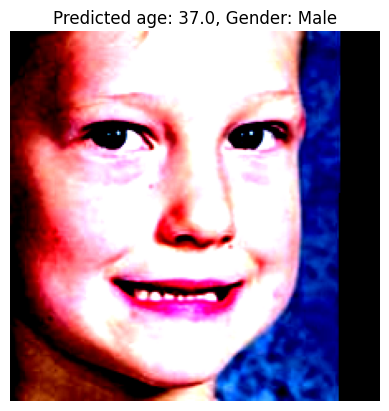

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                         ])
image_path = "/kaggle/input/utkface-new/crop_part1/10_0_0_20170103200522151.jpg.chip.jpg"
age, gender, image = predict_image(model, image_path, transform, device=device)

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted age: {age:.1f}, Gender: {gender}")
plt.show()